In [1]:
import scanpy as sc
import graph_tool.all as gt
import seaborn as sns
import scnsbm
import pandas as pd
import anndata
import pickle
import mygene
import scipy.stats
import statsmodels.api as sm
%pylab
%matplotlib inline

/home/morelli/anaconda3/envs/SCRNA/lib/python3.8/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex
/home/morelli/anaconda3/envs/SCRNA/lib/python3.8/site-packages/graph_tool/draw/cairo_draw.py:39: RuntimeWarning: Error importing cairo. Graph drawing will not work.
  warnings.warn(msg, RuntimeWarning)
/home/morelli/anaconda3/envs/SCRNA/lib/python3.8/site-packages/graph_tool/draw/cairo_draw.py:39: RuntimeWarning: Error importing cairo. Graph drawing will not work.
  warnings.warn(msg, RuntimeWarning)
/home/morelli/anaconda3/envs/SCRNA/lib/python3.8/site-packages/graph_tool/draw/cairo_draw.py:39: RuntimeWarning: Error importing cairo. Graph drawing will not work.
  warnings.warn(msg, RuntimeWarning)
/home/morelli/anaconda3/envs/SCRNA/lib/python3.8/site-packages/graph_tool/all.py:40: RuntimeWarning: Error im

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


In [2]:
adata=sc.read('../../scRNA_paga/state_adata/MARSseq_minimize.h5ad')

<BarContainer object of 10 artists>

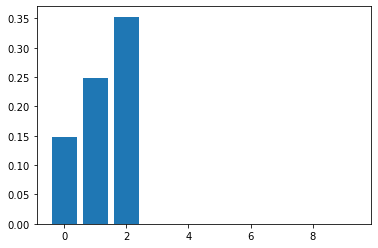

In [3]:
modularity=[x for x in adata.uns['nsbm']['stats']['modularity']]
levels=[x for x in range(len(modularity))]
bar(levels,modularity)

In [4]:
M=adata.uns['nsbm']['cell_affinity']['2']
adata.obs['max_u'] = 1 - np.max(M, axis=1)

In [5]:
adata_affinity=adata[adata.obs.max_u < 1e-100]

Trying to set attribute `.uns` of view, copying.


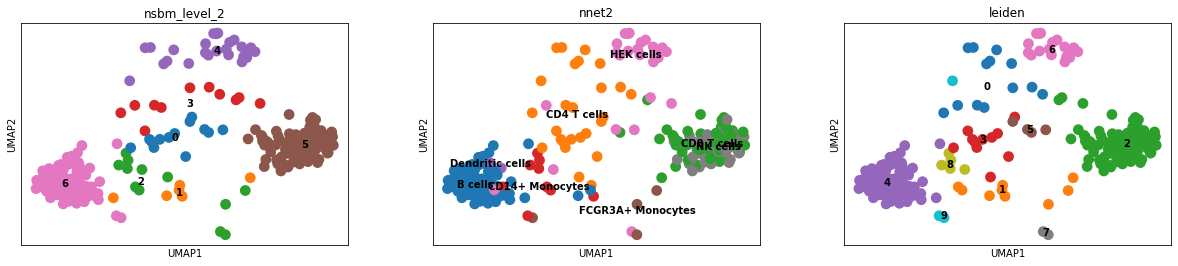

In [6]:
sc.pl.umap(adata_affinity,color=['nsbm_level_2','nnet2','leiden'], legend_loc='on data')

In [31]:
sc.tl.leiden(adata, resolution=0.7)

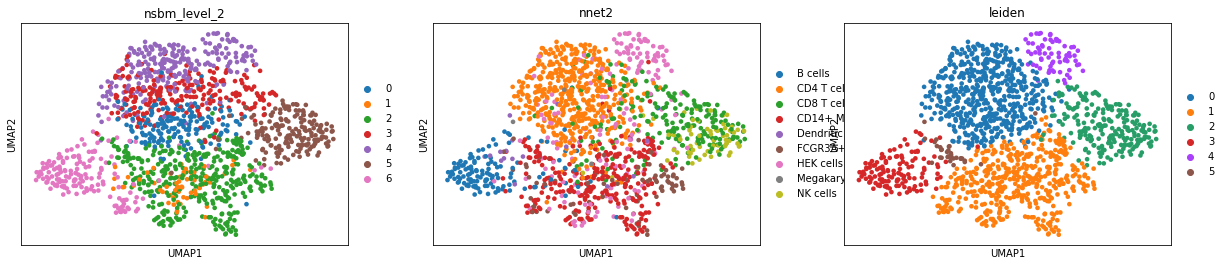

In [32]:
sc.pl.umap(adata,color=['nsbm_level_2','nnet2','leiden'])

In [8]:
level = '2'
marginals = adata.uns['nsbm']['cell_affinity'][level] 
group_names = adata.obs[f'nsbm_level_{level}'].cat.categories
Max = marginals[marginals < 1].max()
Min = marginals[marginals > 0].min()
thr = np.linspace(Min, Max, 10)
thr = np.array([ 10**-x for x in range(0, 11)])

In [9]:
n_cell = adata.obs[f'nsbm_level_{level}'].value_counts().loc[group_names].values
cell_aff = np.max(marginals, axis=1)

D = np.array([adata[cell_aff >  1-t].obs[f'nsbm_level_{level}'].value_counts(sort=False).reindex(group_names, fill_value=0).values for t in thr])

p = D / n_cell
p = p.T

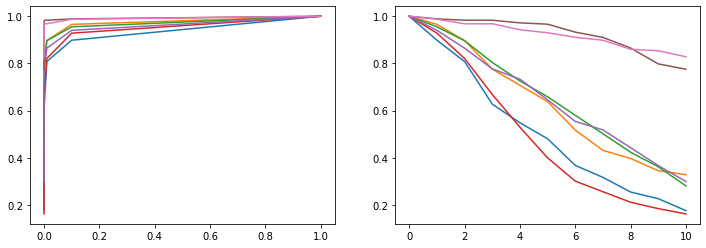

In [10]:
figure(figsize=(12, 4))
subplot(1,2,1)
for x in p:
    plot( thr,x)
subplot(1,2,2)
for x in p:
    plot( x)

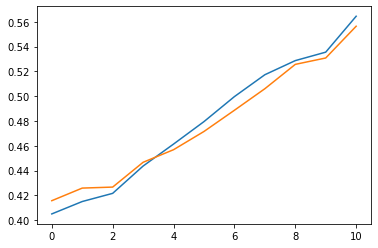

In [27]:
import sklearn
thr = np.array([ 10**-x for x in range(0, 11)])
mi_nsbm=list()
mi_leiden=list()
for i in thr:
    subdata=adata[adata.obs.max_u < i]
    mi_nsbm.append(sklearn.metrics.adjusted_mutual_info_score(subdata.obs.nsbm_level_2, subdata.obs.nnet2))
    mi_leiden.append(sklearn.metrics.adjusted_mutual_info_score(subdata.obs.leiden, subdata.obs.nnet2))
plot(mi_nsbm)
plot(mi_leiden)

In [28]:
MI=0.00
res=0
ciao=np.array(arange(0,1,0.01))
for i in range(len(ciao)):
    sc.tl.leiden(adata,resolution=ciao[i])
    mi=sklearn.metrics.adjusted_mutual_info_score(adata.obs.leiden, adata.obs.nsbm_level_2)
    if mi > MI:
        MI=mi
        res=ciao[i]
    else:continue
print(MI,res)

0.6391710269684094 0.58


In [4]:
import seaborn as sns

<ipython-input-12-53c679e11c4b>:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  flat=pd.Series()
... storing 'flat' as categorical


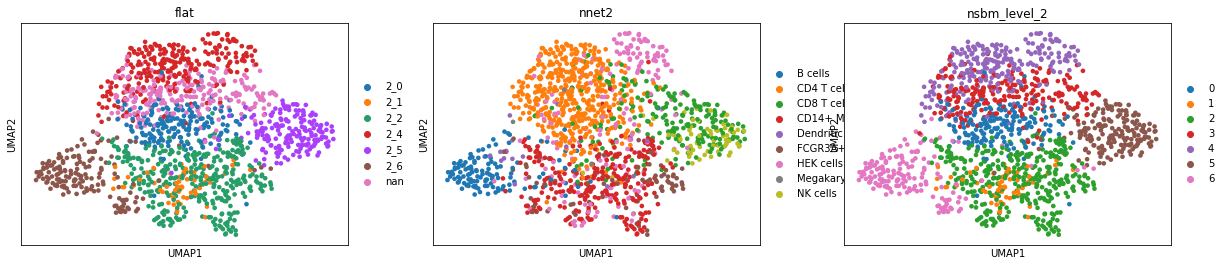

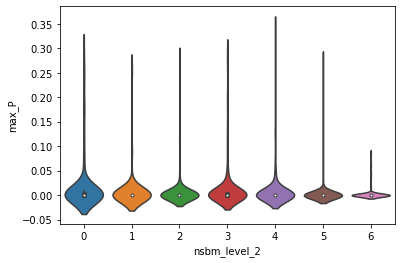

In [12]:
cdata=adata.copy()
flat=pd.Series()
level = str(2)
marginals = cdata.uns['nsbm']['cell_affinity'][level] 
group_names = cdata.obs[f'nsbm_level_{level}'].cat.categories
Max = marginals[marginals < 1].max()
Min = marginals[marginals > 0].min()
thr = np.linspace(Min, Max, 10)
thr = np.array([ 10**-x for x in range(0, 11)])
n_cell = cdata.obs[f'nsbm_level_{level}'].value_counts().loc[group_names].values
cell_aff = np.max(marginals, axis=1)
D = np.array([cdata[cell_aff >  1-t].obs[f'nsbm_level_{level}'].value_counts(sort=False).reindex(group_names, fill_value=0).values for t in thr])
p = D / n_cell
p = p.T
median=np.array([1,0.9,0.8,0.7,0.6,0.6,0.4,0.3,0.2,0.1,0])
for group in group_names:
    group_sign=mean(p[int(group)]-median)
    if group_sign>0:
        a=pd.Series(cdata.obs[f'nsbm_level_{level}'][cdata.obs[f'nsbm_level_{level}']==group], index=cdata.obs[f'nsbm_level_{level}'].index[cdata.obs[f'nsbm_level_{level}']==group])
        a=a.replace(group,str(level+'_'+group))
        flat=pd.Series.append(flat,a, ignore_index=False, verify_integrity=True)
        del_affinities=[x for x in range(len(cdata.obs[f'nsbm_level_{level}'])) if cdata.obs[f'nsbm_level_{level}'][x]==group]
        for i in cdata.uns['nsbm']['cell_affinity']:
            cdata.uns['nsbm']['cell_affinity'][i]=np.delete(cdata.uns['nsbm']['cell_affinity'][i], del_affinities,axis=0)
        cdata=cdata[cdata.obs[f'nsbm_level_{level}']!=group]
adata.obs['flat']=flat
sc.pl.umap(adata, color=['flat','nnet2',f'nsbm_level_{level}'])
fdata=adata
fdata.obs['max_P'] = -np.log10(np.max(marginals, axis=1))
sns.violinplot(x=f'nsbm_level_{level}', y='max_P', data = fdata.obs, scale='width')

In [6]:
cdata=adata.copy()
flat=pd.Series()
level = str(1)
marginals = cdata.uns['nsbm']['cell_affinity'][level] 
group_names = cdata.obs[f'nsbm_level_{level}'].cat.categories
Max = marginals[marginals < 1].max()
Min = marginals[marginals > 0].min()
thr = np.linspace(Min, Max, 10)
thr = np.array([ 10**-x for x in range(0, 11)])
n_cell = cdata.obs[f'nsbm_level_{level}'].value_counts().loc[group_names].values
cell_aff = np.max(marginals, axis=1)
D = np.array([cdata[cell_aff >  1-t].obs[f'nsbm_level_{level}'].value_counts(sort=False).reindex(group_names, fill_value=0).values for t in thr])
p = D / n_cell
p = p.T
median=np.array([1,0.9,0.8,0.7,0.6,0.6,0.4,0.3,0.2,0.1,0])
for group in group_names:
    group_sign=mean(p[int(group)]-median)
    if group_sign>0.25:
        a=pd.Series(cdata.obs[f'nsbm_level_{level}'][cdata.obs[f'nsbm_level_{level}']==group], index=cdata.obs[f'nsbm_level_{level}'].index[cdata.obs[f'nsbm_level_{level}']==group])
        a=a.replace(group,str(level+'_'+group))
        flat=pd.Series.append(flat,a, ignore_index=False, verify_integrity=True)
        del_affinities=[x for x in range(len(cdata.obs[f'nsbm_level_{level}'])) if cdata.obs[f'nsbm_level_{level}'][x]==group]
        for i in cdata.uns['nsbm']['cell_affinity']:
            cdata.uns['nsbm']['cell_affinity'][i]=np.delete(cdata.uns['nsbm']['cell_affinity'][i], del_affinities,axis=0)
        cdata=cdata[cdata.obs[f'nsbm_level_{level}']!=group]
            
adata.obs['flat']=flat
sc.pl.umap(adata, color=['flat','nnet2',f'nsbm_level_{level}'])
#sns.barplot(data=-log10(marginals))
fdata=adata
fdata.obs['max_P'] = -np.log10(np.max(marginals, axis=1))
sns.barplot(x=f'nsbm_level_{level}', y='max_P', data = fdata.obs)

<ipython-input-6-64444e56cf82>:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  flat=pd.Series()


ValueError: zero-size array to reduction operation maximum which has no identity

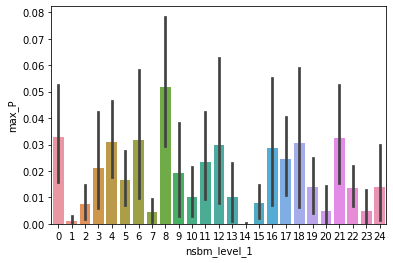

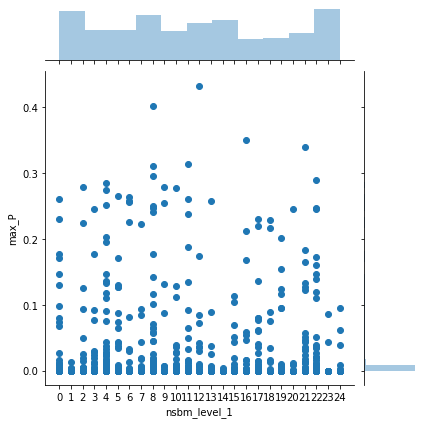

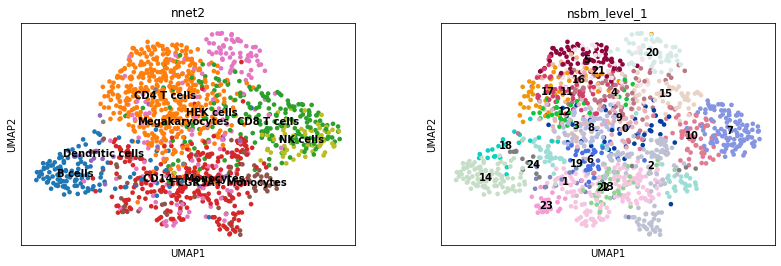

In [5]:
fdata=adata
level=str(1)
marginals = fdata.uns['nsbm']['cell_affinity'][level] 
fdata.obs['max_P'] = -np.log10(np.max(marginals, axis=1))
sns.barplot(x=f'nsbm_level_{level}', y='max_P', data = fdata.obs)
sns.jointplot(x=f'nsbm_level_{level}' , y='max_P', data=fdata.obs)
sc.pl.umap(adata, color=['nnet2',f'nsbm_level_{level}'],legend_loc='on data')

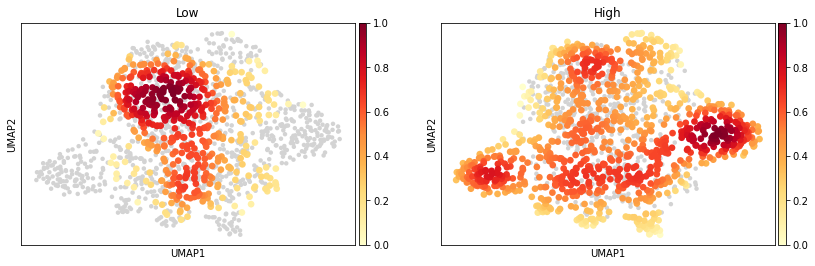

In [9]:
fdata=adata
level=str(2)
marginals = fdata.uns['nsbm']['cell_affinity'][level] 
d = pd.Categorical(np.max(marginals, axis=1) > (1 - 1e-5))
d.rename_categories(['Low', 'High'], inplace=True)
fdata.obs['max_A'] = d
sc.tl.embedding_density(fdata, groupby='max_A', key_added='dense_1')
sc.pl.embedding_density(fdata, key='dense_1')

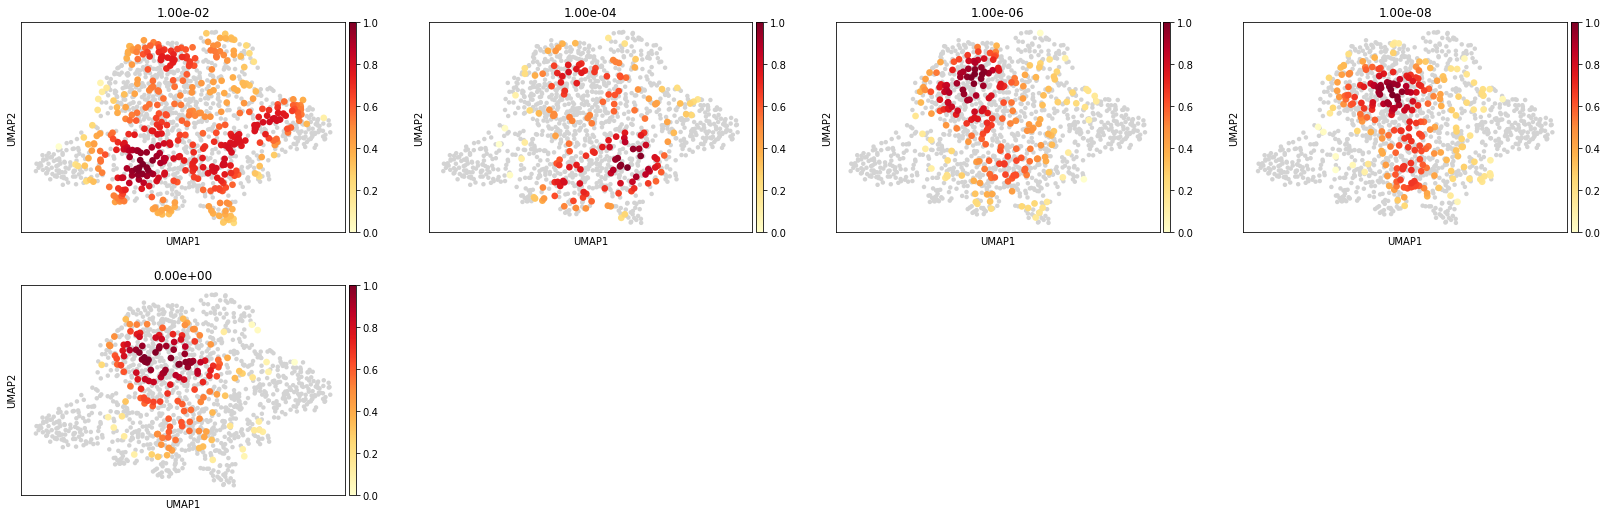

In [10]:
cuts = [0]+ [10**-x for x in range(0, 10, 2)][::-1]
d = pd.Categorical(pd.cut(1-np.max(marginals, axis=1), cuts))
d.rename_categories([f'{x:.2e}' for x in cuts[:-1]][::-1], inplace=True)
fdata.obs['max_A'] = d
sc.tl.embedding_density(fdata, groupby='max_A', key_added='dense_1')
sc.pl.embedding_density(fdata, key='dense_1')

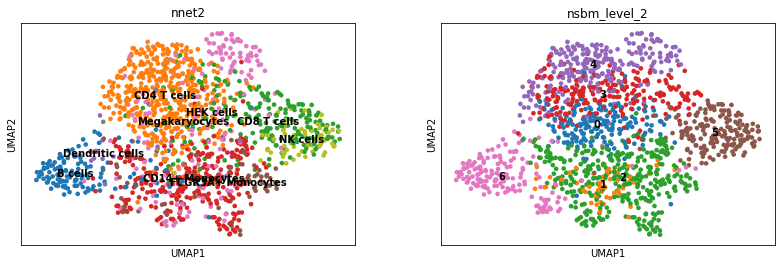

In [3]:
sc.pl.umap(adata,color=['nnet2','nsbm_level_2'],legend_loc='on data')
marginals = adata.uns['nsbm']['cell_affinity']['2'] 
adata.obs['max_P'] = -np.log10(np.max(marginals, axis=1))

In [49]:
adata0=adata[adata.obs['nsbm_level_2']=='6']

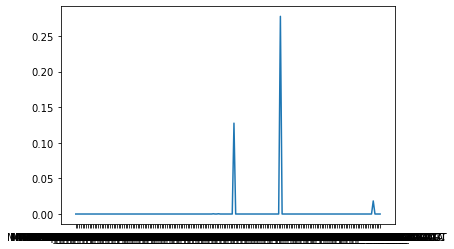

In [43]:
plot(adata0.obs['max_P'])

In [6]:
mean(adata0.obs['max_P'])

0.018254113534337472

In [9]:
mean(adata0.obs['max_P'])

0.007057889632744023

In [12]:
mean(adata0.obs['max_P'])

0.008157513290490139

In [14]:
mean(adata0.obs['max_P'])

0.012751990397157496

In [18]:
mean(adata0.obs['max_P'])

0.010477040517516627

In [21]:
mean(adata0.obs['max_P'])

0.002384066799594659

In [24]:
mean(adata0.obs['max_P'])

0.0015697870382749112

In [25]:
adata0.obs['max_P']

MARSseq_5920AA_CAGGAG   -0.000000e+00
MARSseq_5920AA_CGGAAT   -0.000000e+00
MARSseq_5920AA_GAGTCT   -0.000000e+00
MARSseq_5920AA_GCTATG   -0.000000e+00
MARSseq_5920AA_GTCAAG   -0.000000e+00
                             ...     
MARSseq_5925AA_GCCTAG   -0.000000e+00
MARSseq_5925AA_GCGTCA   -0.000000e+00
MARSseq_5925AA_GTAGTC    9.643275e-17
MARSseq_5925AA_GTCTCA   -0.000000e+00
MARSseq_5925AA_TGCAGC   -0.000000e+00
Name: max_P, Length: 157, dtype: float64

In [29]:
c=0
for i in adata0.obs['max_P']:
    if i>0.05:
        c=c+1
c=c/(len(adata0.obs['max_P']))
print(c)

0.1016949152542373


In [32]:
c=0
for i in adata0.obs['max_P']:
    if i>0.05:
        c=c+1
c=c/(len(adata0.obs['max_P']))
print(c)

0.034482758620689655


In [35]:
c=0
for i in adata0.obs['max_P']:
    if i>0.05:
        c=c+1
c=c/(len(adata0.obs['max_P']))
print(c)

0.04201680672268908


In [38]:
c=0
for i in adata0.obs['max_P']:
    if i>0.05:
        c=c+1
c=c/(len(adata0.obs['max_P']))
print(c)

0.06726457399103139


In [41]:
c=0
for i in adata0.obs['max_P']:
    if i>0.05:
        c=c+1
c=c/(len(adata0.obs['max_P']))
print(c)

0.055776892430278883


In [44]:
c=0
for i in adata0.obs['max_P']:
    if i>0.05:
        c=c+1
c=c/(len(adata0.obs['max_P']))
print(c)

0.011235955056179775


In [50]:
c=0
for i in adata0.obs['max_P']:
    if i>0.05:
        c=c+1
c=c/(len(adata0.obs['max_P']))
print(c)

0.012738853503184714


In [52]:
group_sig=[]
group_names = adata.obs[f'nsbm_level_{2}'].cat.categories
for group in group_names:
    adata0=adata[adata.obs['nsbm_level_2']==group]
    c=0
    for i in adata0.obs['max_P']:
        if i>0.05:
            c=c+1
    c=c/(len(adata0.obs['max_P']))
    group_sig.append(c)
print(group_sig)

[0.1016949152542373, 0.034482758620689655, 0.04201680672268908, 0.06726457399103139, 0.055776892430278883, 0.011235955056179775, 0.012738853503184714]


In [46]:
len(adata0.obs['max_P'])

157

In [47]:
c

0.006409996348736257

In [51]:
0.012738853503184714/2


0.006369426751592357

<ipython-input-5-ef7c6c5936d1>:15: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  flat=pd.Series()
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


1
2
7
10
13
14
20
23


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


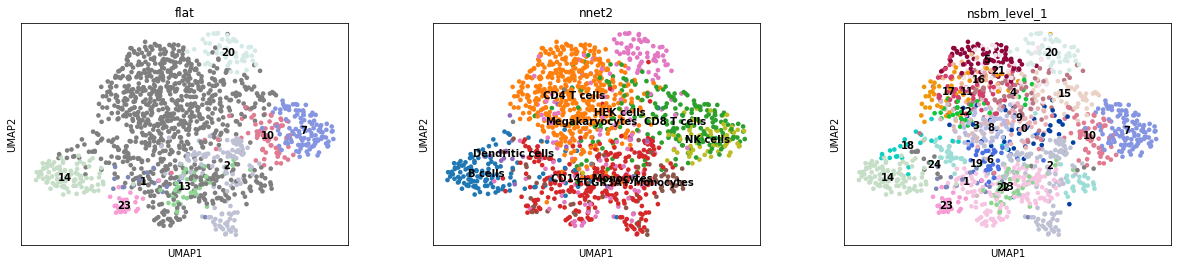

[0.2127659574468085, 0.0, 0.034482758620689655, 0.11428571428571428, 0.15789473684210525, 0.10666666666666667, 0.13513513513513514, 0.02727272727272727, 0.2727272727272727, 0.1, 0.04411764705882353, 0.11290322580645161, 0.12903225806451613, 0.047619047619047616, 0.0, 0.07407407407407407, 0.15151515151515152, 0.17777777777777778, 0.18181818181818182, 0.1016949152542373, 0.018867924528301886, 0.17777777777777778, 0.06896551724137931, 0.037037037037037035, 0.13333333333333333]


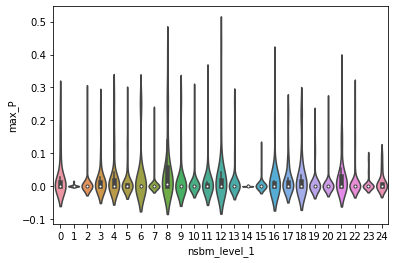

In [5]:
level=str(1)
marginals = adata.uns['nsbm']['cell_affinity'][level] 
adata.obs['max_P'] = -np.log10(np.max(marginals, axis=1))
group_sig=[]
group_names = adata.obs[f'nsbm_level_{level}'].cat.categories
for group in group_names:
    adata0=adata[adata.obs[f'nsbm_level_{level}']==group]
    c=0
    for i in adata0.obs['max_P']:
        if i>0.05:
            c=c+1
    c=c/(len(adata0.obs['max_P']))
    group_sig.append(c)
cdata=adata
flat=pd.Series()
for i in range(len(group_sig)):
    if group_sig[i]<0.05:
        a=pd.Series(cdata.obs[f'nsbm_level_{level}'][cdata.obs[f'nsbm_level_{level}']==str(i)], index=cdata.obs[f'nsbm_level_{level}'].index[cdata.obs[f'nsbm_level_{level}']==str(i)])
        flat=pd.Series.append(flat,a, ignore_index=False, verify_integrity=True)
        print(i)
cdata.obs['flat']=flat
sc.pl.umap(cdata, color=['flat','nnet2',f'nsbm_level_{level}'],legend_loc='on data')
print(group_sig)

sns.violinplot(x=f'nsbm_level_{level}', y='max_P', data = adata.obs, scale='width')

<ipython-input-4-2c9828030d0a>:17: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  flat=pd.Series()
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should

1
7
14
20


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


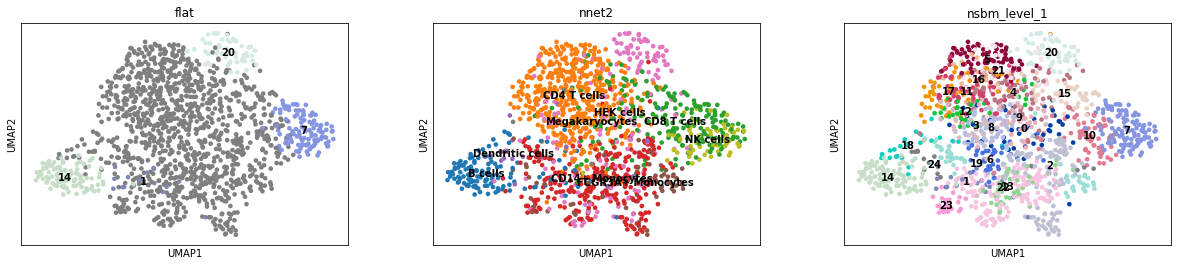

[0.7659574468085106, 1.0, 0.9482758620689655, 0.8, 0.7631578947368421, 0.84, 0.8108108108108109, 0.9636363636363636, 0.6727272727272727, 0.9, 0.8970588235294118, 0.8548387096774194, 0.7419354838709677, 0.9047619047619048, 1.0, 0.9074074074074074, 0.8181818181818182, 0.7555555555555555, 0.7727272727272727, 0.8983050847457628, 0.9811320754716981, 0.6888888888888889, 0.903448275862069, 0.9259259259259259, 0.8]


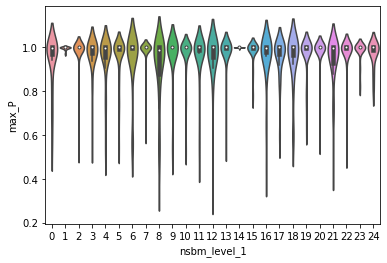

In [4]:
level=str(1)
marginals = adata.uns['nsbm']['cell_affinity'][level] 
#adata.obs['max_P'] = -np.log10(np.max(marginals, axis=1))
adata.obs['max_P'] = np.max(marginals,axis=1)
group_sig=[]
group_names = adata.obs[f'nsbm_level_{level}'].cat.categories
for group in group_names:
    adata0=adata[adata.obs[f'nsbm_level_{level}']==group]
    c=0
    for i in adata0.obs['max_P']:
#        if i<0.05:
        if i>0.95:
            c=c+1
    c=c/(len(adata0.obs['max_P']))
    group_sig.append(c)
cdata=adata
flat=pd.Series()
for i in range(len(group_sig)):
#    if group_sig[i]<0.05:
    if group_sig[i]>0.95:
        a=pd.Series(cdata.obs[f'nsbm_level_{level}'][cdata.obs[f'nsbm_level_{level}']==str(i)], index=cdata.obs[f'nsbm_level_{level}'].index[cdata.obs[f'nsbm_level_{level}']==str(i)])
        flat=pd.Series.append(flat,a, ignore_index=False, verify_integrity=True)
        print(i)
cdata.obs['flat']=flat
sc.pl.umap(cdata, color=['flat','nnet2',f'nsbm_level_{level}'],legend_loc='on data')
print(group_sig)

sns.violinplot(x=f'nsbm_level_{level}', y='max_P', data = adata.obs, scale='width')